In [1]:
using Revise
using Pkg; Pkg.activate(".")

using Dates
using Interpolations
using PyPlot
using MAT

# include("../mast/readers.jl")
# using .ShipPosmv

  Activating project at `~/Projects/ASTRAL/lidar`


from file: vectornav.h

#define IDX_TIMEGPS 0
#define IDX_YAW 1
#define IDX_PITCH 2
#define IDX_ROLL 3
#define IDX_QUAT0 4
#define IDX_QUAT1 5
#define IDX_QUAT2 6
#define IDX_QUAT3 7
#define IDX_LATITUDE 8
#define IDX_LONGITUDE 9
#define IDX_ALTITUDE 10
#define IDX_MAGNED0 11
#define IDX_MAGNED1 12
#define IDX_MAGNED2 13
#define IDX_LINACC0 14
#define IDX_LINACC1 15
#define IDX_LINACC2 16
#define IDX_VELNED0 17
#define IDX_VELNED1 18
#define IDX_VELNED2 19

from file:  vectornav.cpp

  shared_memory->name(
    "GpsTime",
    "Yaw", "Pitch", "Roll",
    "Quat0", "Quat1", "Quat2", "Quat3",
    "Latitude", "Longitude", "Altitude",
    "MagNED0", "MagNED1", "MagNED2",
    "LinAcc0", "LinAcc1", "LinAcc2",
    "VelNED0", "VelNED1", "VelNED2");

To decode these variables, you need to look at the VectorNav variable description located in \ceees-lidar-platform-master\lib-src\vnproglib-1.1\index.html
under sensor class.

In [26]:
# read the VectorNav file
# line:
# Tue Mar 28 13:17:11 2023 +0000, 9431257000, -163.267792, -1.067281, -1.441135, -0.011044, 0.011087, -0.989255, 0.145364, 0.000000, 0.000000, 0.000000, 0.234963, -0.005458, 0.101274, 0.432598, -0.534912, -9.797964, 0.000000, 0.000000, 0.000000
#
# 21 science data fields delimited by commas

function read_vevnav_data( file )
    # allocate arrays
    nlmax = countlines(file)
    dt = Vector{DateTime}(undef, nlmax)
    intdata = Matrix{Int64}(undef, nlmax, 2)
    data = Matrix{Float32}(undef, nlmax, 19)

    # read it >>BLACK PUMAS<<
    nl = 0
    df = dateformat"uuuHH:MM:SSyyyy"
    open( file ) do f
        for line in readlines(f)
            # Tue Mar 28 13:17:11 2023 +0000, 9431257000, -163.267792, -1.067281, -1.441135, -0.011044, 0.011087, -0.989255, 0.145364, 0.000000, 0.000000, 0.000000, 0.234963, -0.005458, 0.101274, 0.432598, -0.534912, -9.797964, 0.000000, 0.000000, 0.000000
            nl += 1
            spl = split(line, r"[\ ,]+")
            try
                dt[nl] = ( 
                    DateTime(spl[2], dateformat"u") + Day(parse(Int8, spl[3])) 
                  + Year(parse(Int16, spl[5])-1) 
                  +(DateTime(spl[4], dateformat"HH:MM:SS") - DateTime(1,1,1)) )
                intdata[nl,:] .= parse.(Int64, spl[6:7])  #  2
                data[nl,:] .= parse.(Float32, spl[8:end]) # 19
            catch
                @show line
            end
        end
    end
    return dt[1:nl], intdata[1:nl,:], data[1:nl,:]
end

function read_vecnav_dict( file )

    D = Dict{Symbol, Any}()
    vnkeys = Symbol.( [
    "Yaw", "Pitch", "Roll",
    "Quat0", "Quat1", "Quat2", "Quat3",
    "Latitude", "Longitude", "Altitude",
    "MagNED0", "MagNED1", "MagNED2",
    "LinAcc0", "LinAcc1", "LinAcc2",
    "VelNED0", "VelNED1", "VelNED2" ] )

    dt, gpstime, data = read_vevnav_data( file )

    D[:time] = dt
    D[:GpsTime] = gpstime[:,2]
    for (i,k) in enumerate(vnkeys)
        D[k] = data[:,i]
    end
    return D
end


read_vecnav_dict (generic function with 1 method)

In [27]:
# precompile reader on a short file
test = read_vecnav_dict( "./data/lidar/table/VNshort.txt" ) 

Dict{Symbol, Any} with 21 entries:
  :LinAcc1   => Float32[-0.534912, 0.242155, -0.252161, -0.142886, 0.870555, -0…
  :Roll      => Float32[-1.44114, -1.4784, -1.4599, -1.51939, -1.4881, -1.55684…
  :Latitude  => Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.…
  :Yaw       => Float32[-163.268, -163.09, -163.29, -163.131, -163.282, -163.13…
  :time      => [DateTime("2023-03-29T13:17:11"), DateTime("2023-03-29T13:17:11…
  :VelNED1   => Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.…
  :MagNED2   => Float32[0.101274, 0.102987, 0.101529, 0.10302, 0.101723, 0.1018…
  :Altitude  => Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.…
  :Quat1     => Float32[0.011087, 0.011421, 0.011312, 0.011824, 0.01162, 0.0122…
  :VelNED2   => Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.…
  :MagNED0   => Float32[0.234963, 0.238538, 0.237532, 0.239332, 0.240921, 0.241…
  :Quat0     => Float32[-0.011044, -0.010909, -0.010645, -0.010649, -0.010

In [28]:
# read whole VecNav data file
file = "./data/lidar/table/VectorNavTableData.txt"
@time Vn = read_vecnav_dict( file ) # very big slow read takes 2:27; !compile first!
# (dt, intdata, data) = ans

410.429126 seconds (730.31 M allocations: 72.999 GiB, 9.21% gc time)


Dict{Symbol, Any} with 21 entries:
  :LinAcc1   => Float32[-0.534912, 0.242155, -0.252161, -0.142886, 0.870555, -0…
  :Roll      => Float32[-1.44114, -1.4784, -1.4599, -1.51939, -1.4881, -1.55684…
  :Latitude  => Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  13…
  :Yaw       => Float32[-163.268, -163.09, -163.29, -163.131, -163.282, -163.13…
  :time      => [DateTime("2023-03-29T13:17:11"), DateTime("2023-03-29T13:17:11…
  :VelNED1   => Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -0…
  :MagNED2   => Float32[0.101274, 0.102987, 0.101529, 0.10302, 0.101723, 0.1018…
  :Altitude  => Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -7…
  :Quat1     => Float32[0.011087, 0.011421, 0.011312, 0.011824, 0.01162, 0.0122…
  :VelNED2   => Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -0…
  :MagNED0   => Float32[0.234963, 0.238538, 0.237532, 0.239332, 0.240921, 0.241…
  :Quat0     => Float32[-0.011044, -0.010909, -0.010645, -0.010649, -0.010

In [77]:
# plot(Vn[:GpsTime][1200:1200:end], marker=".", linestyle="none") # jumps
# plot(Vn[:time][1200:1200:end], marker=".", linestyle="none") # monotonic
i0 = findfirst(diff(Vn[:GpsTime][:]) .> 1e17)+1
# i0=663 # first good index

663

In [78]:
diff(Vn[:GpsTime][700:712]) # integer nanoseconds = 10-9 s
# 50_000_000 ns is 0.05 s

function gps2dt(gpstime::Integer)
    t_d = floor(gpstime / (86_400 * 1_000_000_000)) # nanosecond -> integer day
    t_ms = round(Int64, (gpstime % (86_400 * 1_000_000_000) ) / 1_000_000) # nansecond -> millisecond of day
    DateTime(1980, 1, 6, 0,0,0) + Day(t_d) + Millisecond(t_ms)
end
gps2dt(gpstime::Vector) = gps2dt.(gpstime)

# fix the time
delete!(Vn, :time)
Vn[:time] = gps2dt(Vn[:GpsTime]) # re-add
# first good index = 663

# time interpolator, truncates
itp_vn(k, t) = interpolate(Dates.value.(Vn[:time][i0:end]), Vn[k][i0:end])[t]

itp_vn (generic function with 1 method)

In [80]:
# write in a mat file
using MAT

i0=663 # first good index
matopen("VectorNavTable.mat", "w") do matfile
    # Write the variables to the MAT file
    write(matfile, "time_offset", Dates.value.(Vn[:time][i0:end] .- Vn[:time][i0])) # millisec since base_time
    write(matfile, "base_time",  Dates.format( Vn[:time][i0], "yyyy-mm-dd HH:MM:SS.sss" ))
    for k in filter(k -> k !== :time, keys(Vn))
        write(matfile, String(k), Vn[k][i0:end])
    end
    close(matfile)
end

using JLD2

jldopen("VectorNavTable.jld2", "w") do file
    # Write the VectorNav dict to the JLD2 file
    file["Vn"] = Vn
end

Dict{Symbol, Any} with 21 entries:
  :LinAcc1   => Float32[-0.534912, 0.242155, -0.252161, -0.142886, 0.870555, -0…
  :Roll      => Float32[-1.44114, -1.4784, -1.4599, -1.51939, -1.4881, -1.55684…
  :Latitude  => Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  13…
  :Yaw       => Float32[-163.268, -163.09, -163.29, -163.131, -163.282, -163.13…
  :time      => [DateTime("1980-01-06T00:00:09.431"), DateTime("1980-01-06T00:0…
  :VelNED1   => Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -0…
  :MagNED2   => Float32[0.101274, 0.102987, 0.101529, 0.10302, 0.101723, 0.1018…
  :Altitude  => Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -7…
  :Quat1     => Float32[0.011087, 0.011421, 0.011312, 0.011824, 0.01162, 0.0122…
  :VelNED2   => Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -0…
  :MagNED0   => Float32[0.234963, 0.238538, 0.237532, 0.239332, 0.240921, 0.241…
  :Quat0     => Float32[-0.011044, -0.010909, -0.010645, -0.010649, -0.010

In [84]:
# now read just the time
file = jldopen("VectorNavTable.jld2", "r")
vn_dt = file["Vn"][:time]
close(file)

In [104]:
# subset
st = findfirst(dt -> dt >= DateTime(2024,5,1,0,0,0), vn_dt )
en = findlast( dt -> dt <  DateTime(2024,5,1,1,0,0), vn_dt )

# l  = Vectopitch = Vector{Float32}(undef, en-st+1) # slower
# rolr{Float32}(undef, en-st+1)

file = jldopen("VectorNavTable.jld2", "r") # subsetting saves no time
    pitch = file["Vn"][:Pitch]   # degrees 
    roll  = file["Vn"][:Roll]    # degrees
    heave = file["Vn"][:VelNED2] # m/s
close(file)

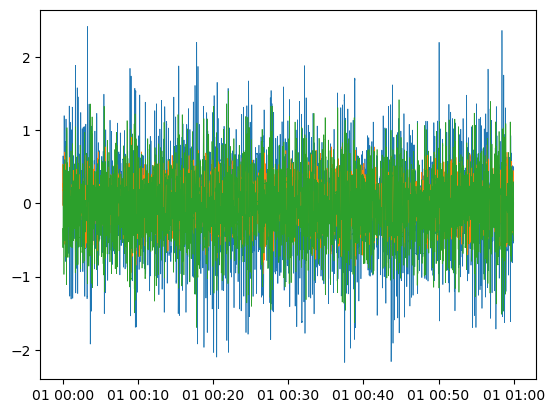

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x80465f4f0>

In [105]:
plot(vn_dt[st:en],  roll[st:en], linewidth=0.5) # RollPitchYaw in degrees
plot(vn_dt[st:en], pitch[st:en], linewidth=0.5)
plot(vn_dt[st:en], heave[st:en], linewidth=0.5) # heave of the body in NED frame in m/s

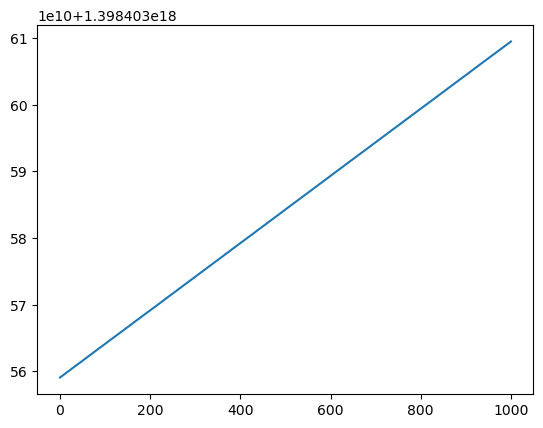

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x333034cd0>

In [97]:
heave = Vn[:VelNED2] # m/s?

# trigonometry to find displacements between volumes to be used in structure functions
target_vector(range, pitch, roll) = range .* [ -sin(pitch), cos(pitch)*sin(roll), cos(pitch)*cos(roll) ]
#simultaneous_vector(a1,a2, p1,p2, r1,r2) = target_vector(a1,p1,r1) .- target_vector(a2,p2,r2)
displacement_vector(X, Y, a1,a2, p1,p2, r1,r2) = [X, Y, 0] .- (target_vector(a1,p1,r1) .- target_vector(a2,p2,r2))
rad = abs(displacement_vector)
r1 = abs(displacement_vector[1])


In [ ]:

#=
% turbulece constants
crosscomp  = 3 / 4;
kolmogorov = 0.54; % Matches atmospheric boundary layer estimates and Sreenivasan 1995
% kolmogorov=0.5; % probably only 1 digit of precision, Sreenivasan 1995
C1prime = 4 / 3 * kolmogorov; % as in Pope eqn 6.243
factr   = crosscomp / kolmogorov; % 1/C1prime, used for my dissipation calculation
% S(w; k) = C1primt * epsilon^2/3 k^-5/3
% universal constant for 2nd order structure function
% longitudinal structure function constant C2 from Pope 6.2 (p.193) after Saddoughi and Veeravalli (1994)

factrz = 1 / C2ll;
factrx = 3 / 4 / C2ll;
=#

# stucture function
C2ll = 2.0
struf(epsilon, r,r1) = C2ll epsilon^(2/3) r^(2/3) (4 - (r1/r)^2)/3
instruf(w1,w2) = (w1-w2)^2
rho(r1,r) = r^(2/3) * (1 - ((r1/r)^2)/4)
zmid(z1,z2) = (z1 + z2) / 2
# plot bin averaged instruf vs rho
# fit 
# D = A*rho + noise
# for A and noise
# A = 4/3 * C2ll * epsilon^(2/3)
espsilon(A) = sqrt(3/4 * A/C2ll)^3